In [296]:
import pandas as pd
import seaborn as sns

"""
The COVID-19 pandemic impacted many aspects of our lives - in particular, how mobile we are.
Google collects location data, aggregated and anonymised, for the purposes of research.

These datasets show how visits and length of stay at different places change compared to a baseline. We calculate these changes using the same kind of aggregated and anonymized data used to show popular times for places in Google Maps.

Changes for each day are compared to a baseline value for that day of the week. The baseline is the median value, for the corresponding day of the week, during the 5-week period Jan 3–Feb 6, 2020.

Google LLC "Google COVID-19 Community Mobility Reports".
https://www.google.com/covid19/mobility/ Accessed: 25 January 2022.

"""

df_brisbane_2020 = pd.read_csv('2020_AU_Region_Mobility_Report.csv')
df_singapore_2020 = pd.read_csv('2020_SG_Region_Mobility_Report.csv')
df_brisbane_2021 = pd.read_csv('2021_AU_Region_Mobility_Report.csv')
df_singapore_2021 = pd.read_csv('2021_SG_Region_Mobility_Report.csv')

In [297]:
df_brisbane = pd.concat([df_brisbane_2020, df_brisbane_2021])
df_singapore = pd.concat([df_singapore_2020, df_singapore_2021])

In [298]:
def preprocess(df):
# Stack and clean-up column values
    df = df[[
        'place_id', 
        'sub_region_1',
        'sub_region_2', 
        'date', 
        'retail_and_recreation_percent_change_from_baseline',
        'grocery_and_pharmacy_percent_change_from_baseline',
        'parks_percent_change_from_baseline',
        'transit_stations_percent_change_from_baseline',
        'workplaces_percent_change_from_baseline',
        'residential_percent_change_from_baseline'
        ]]

    df = df.rename(columns={
        'retail_and_recreation_percent_change_from_baseline': 'retail_and_recreation',
        'parks_percent_change_from_baseline': 'parks',
        'grocery_and_pharmacy_percent_change_from_baseline': 'grocery_and_pharmacy',
        'transit_stations_percent_change_from_baseline': 'public_transport',
        'workplaces_percent_change_from_baseline': 'workplaces',
        'residential_percent_change_from_baseline': 'residential'
    })
    df = df.set_index(['place_id', 'sub_region_1', 'sub_region_2', 'date'])
    df = df.stack(0)
    df = df.reset_index()
    df = df.rename(columns={
        0: "pct_change",
        'level_4': 'category',
    })
    df['pct_change'] = df['pct_change']/100 # Convert to proper %

    return df

df_brisbane = preprocess(df_brisbane)
df_singapore = preprocess(df_singapore)

In [299]:
# Plot settings
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use('fivethirtyeight')
sns.set_theme(style="whitegrid")
import matplotlib.ticker as mtick
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 11, 9 #Changes default matplotlib plots to this size

# DPI settings
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

pd.options.display.float_format = '{:.2%}'.format

In [300]:
def plot_mobility_data(datasets):
    """Plots Mobility
    :param datasets:
    :param List[Dict]: 
    :rtype fig
    """
    # Format axis
    date_range = [d.strftime('%Y-%m-%d') for d in pd.date_range(start=data['date'].min(),end=data['date'].max(), freq="M")]

    # Identify annotations

    # Plot the charts
    fig, ax = plt.subplots(2,1, figsize=(15,12))

    for i in range(len(datasets)):
        plot_data = datasets[i]['dataset']

        sns.lineplot(
            ax=ax[i],
            data=plot_data,
            x='date',
            y='pct_change',
            hue='category',
            palette=datasets[i]['palette']
        )

        # Format the plot
        ax[i].yaxis.set_major_formatter(mtick.PercentFormatter())
        ax[i].legend(title = "Category", loc='upper right')
        ax[i].set_title(datasets[i]['title'], fontsize=20)
        ax[i].set_xticks(date_range)
        ax[i].set_xticklabels(labels=date_range, rotation=30)
        ax[i].set_ylabel('% change in mobility (compared to baseline)')  
        ax[i].set_xlabel('')

        # Annotations
        # https://www.who.int/en/activities/tracking-SARS-CoV-2-variants/
        # 1st Wave
        ax[i].axvline(
            x='2020-03-30',
            color='k',
            linestyle='--'   
        )
        ax[i].text(
            x='2020-03-30', 
            y=-0.8, 
            s='Original Variant', 
            fontsize=12
        )

        # 2nd Wave - Alpha and Beta
        ax[i].axvline(
            x='2020-12-18',
            color='k',
            linestyle='--'   
        )
        ax[i].text(
            x='2020-12-18', 
            y=-0.8, 
            s='Alpha/Beta Variant', 
            fontsize=12
        )

        # 3rd Wave - Delta
        ax[i].axvline(
            x='2021-04-04',
            color='k',
            linestyle='--'   
        )

        ax[i].text(
            x='2021-04-04', 
            y=-0.8, 
            s='Delta Variant',  
            fontsize=12
        )

        # 4th Wave - Omicron
        ax[i].axvline(
            x='2021-11-24',
            color='k',
            linestyle='--'   
        )

        ax[i].text(
            x='2021-11-24', 
            y=-0.8, 
            s='Omicron Variant',  
            fontsize=12
        )

    return fig

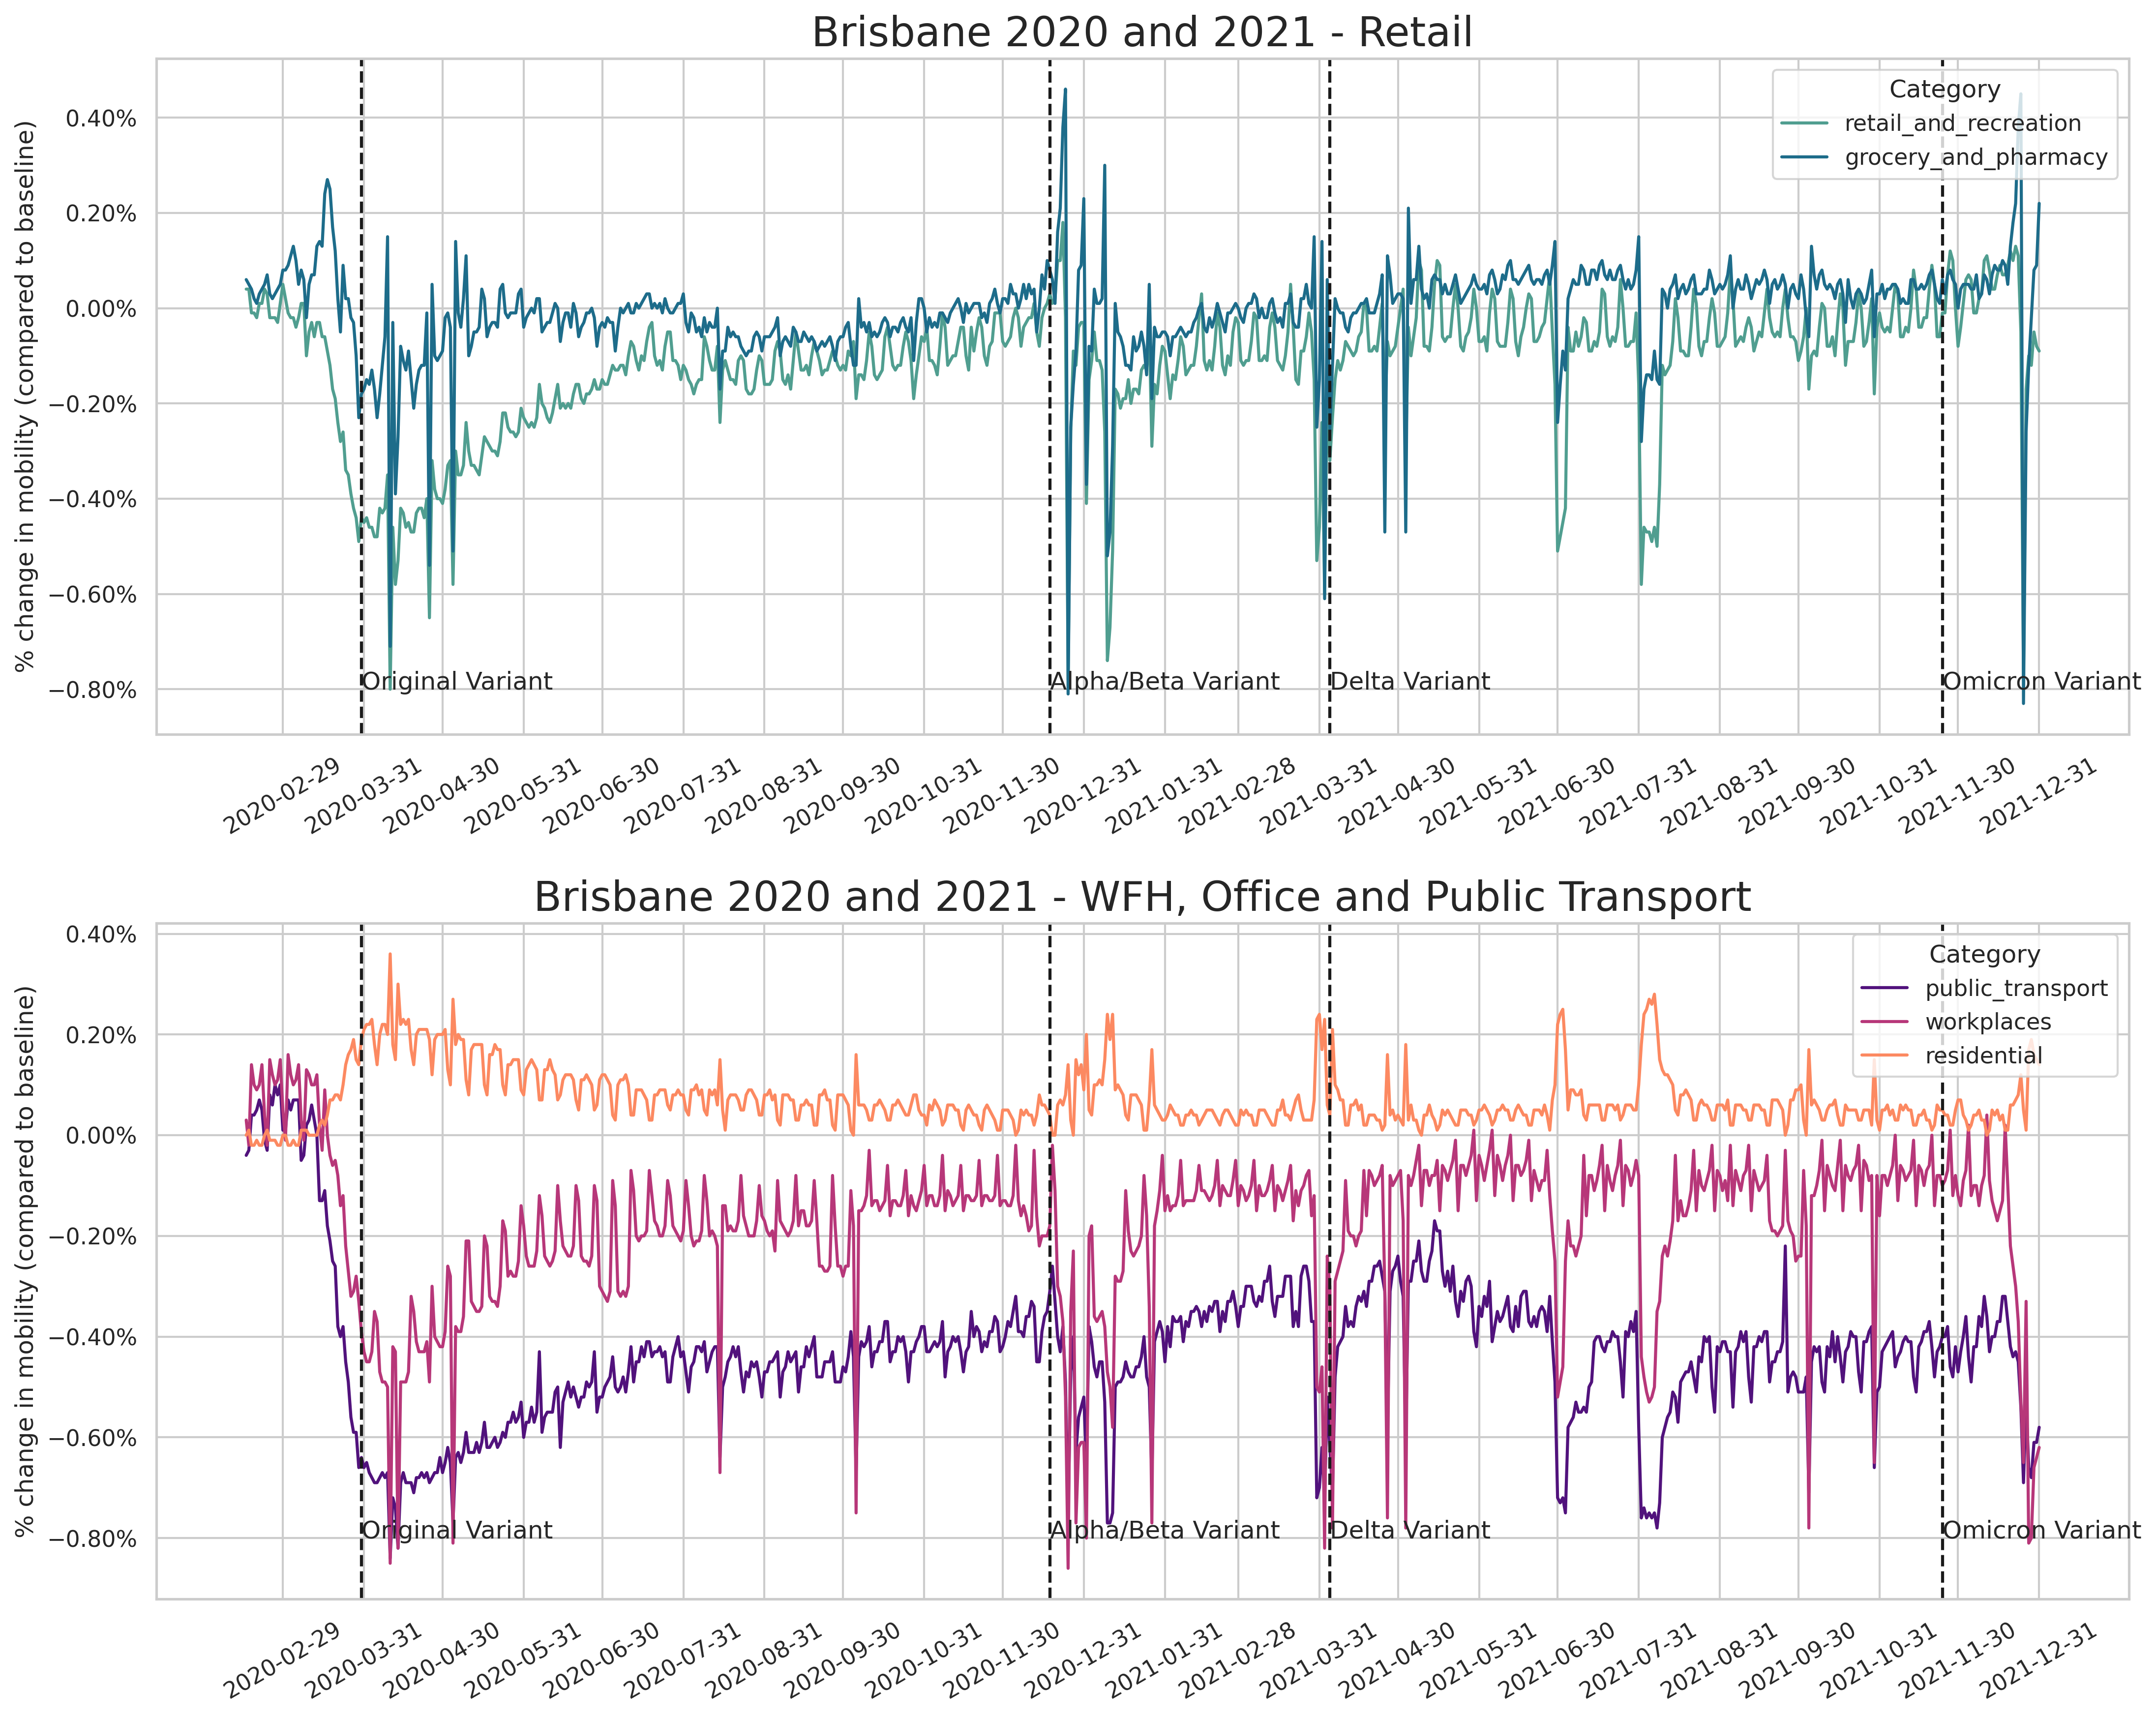

In [301]:
"""
First plot Greater Brisbane area
"""

# Filter down to Greater Brisbane area
data = df_brisbane[df_brisbane['sub_region_2'].isin(['Brisbane City', 'City of Ipswich', 'Logan City', 'Redland City', 'Moreton Bay Region'])]
# Filter down to Brisbane
data = data[data['sub_region_2'] == 'Brisbane City']
datasets = [
    {
        'dataset': data[data['category'].isin(['retail_and_recreation', 'grocery_and_pharmacy'])],
        'title': 'Brisbane 2020 and 2021 - Retail',
        'subtitle': 'Showing the impact of lockdowns on retail',
        'palette': 'crest'
    },
    {
        'dataset': data[data['category'].isin(['workplaces', 'residential', 'public_transport'])],
        'title': 'Brisbane 2020 and 2021 - WFH, Office and Public Transport',
        'subtitle': 'Showing the impact of WFH and hybrid arrangements',
        'palette': 'magma'
    }
]

fig = plot_mobility_data(datasets)

plt.tight_layout(pad=2.0)
plt.show()

Interestingly, you can see the initial hit from the variants hit retail particularly hard.

Workplaces also show a significant drop in traffic right after a new variant, but gradually come back.

You can also see that workplace traffic has still not returned to pre-COVID levels.

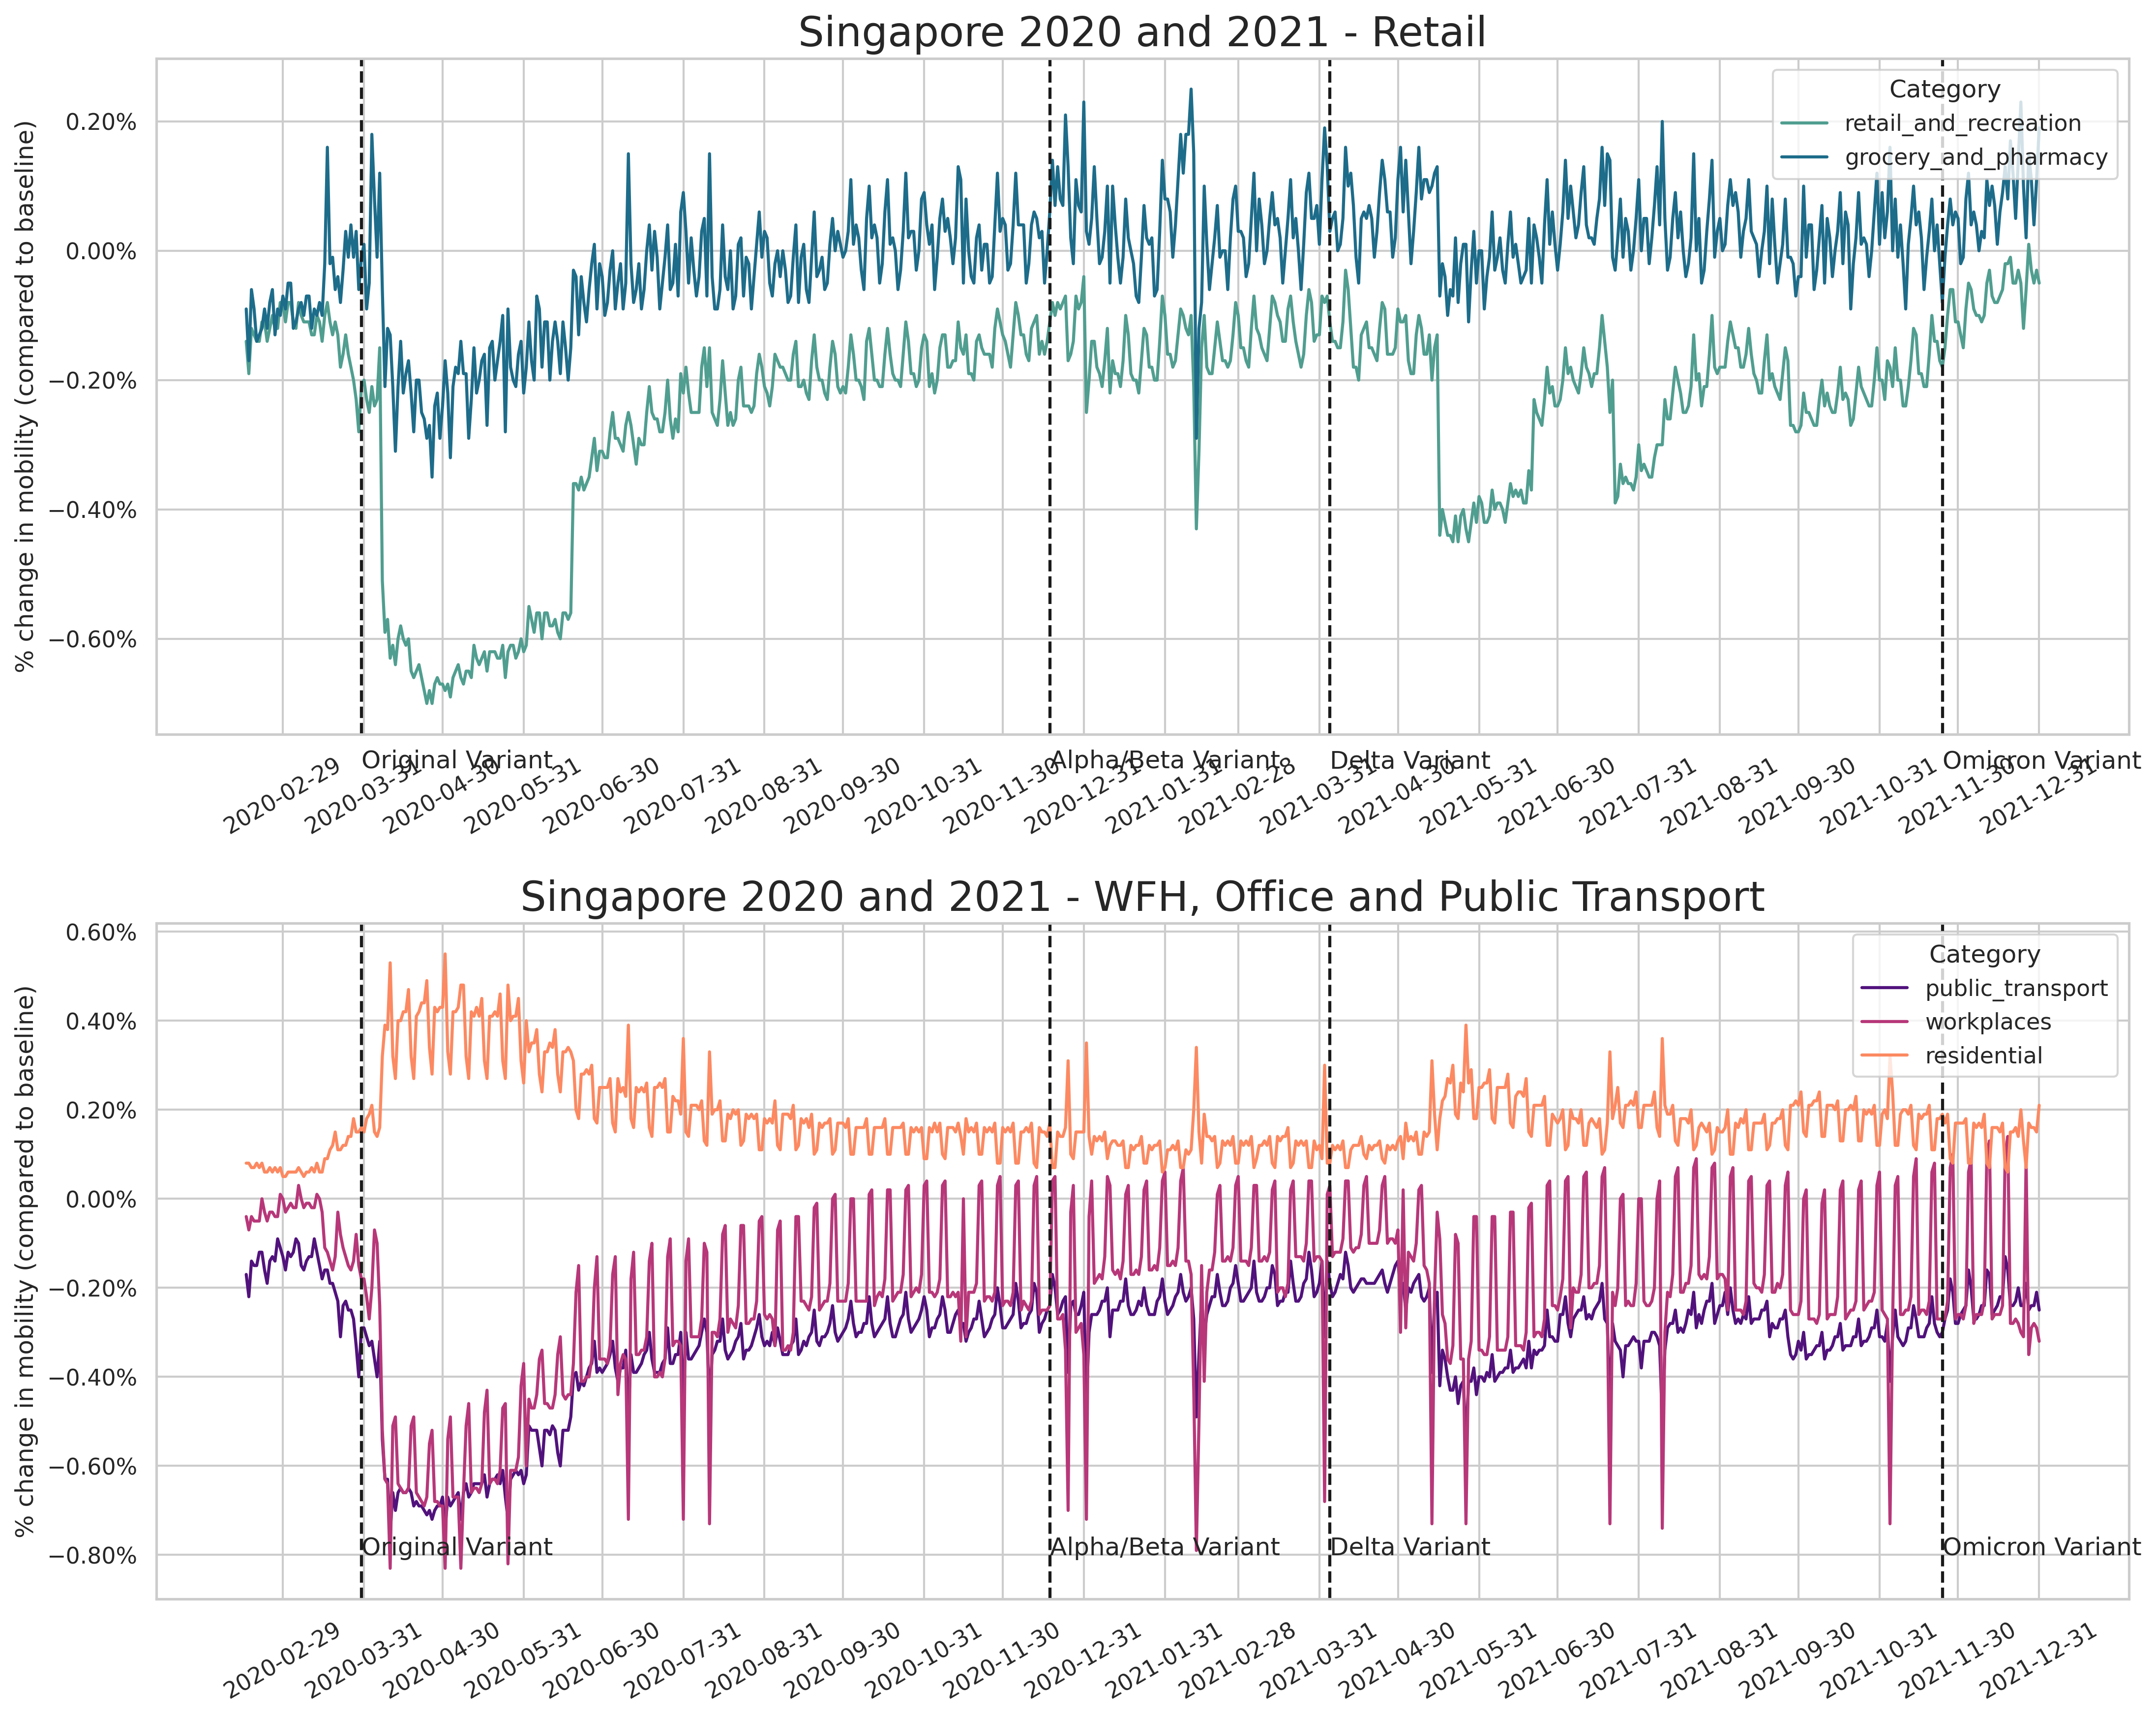

In [302]:
"""
Next plot Singapore
"""

data = df_singapore
datasets = [
    {
        'dataset': data[data['category'].isin(['retail_and_recreation', 'grocery_and_pharmacy'])],
        'title': 'Singapore 2020 and 2021 - Retail',
        'subtitle': 'Showing the impact of lockdowns on retail',
        'palette': 'crest'
    },
    {
        'dataset': data[data['category'].isin(['workplaces', 'residential', 'public_transport'])],
        'title': 'Singapore 2020 and 2021 - WFH, Office and Public Transport',
        'subtitle': 'Showing the impact of WFH and hybrid arrangements',
        'palette': 'magma'
    }
]

fig = plot_mobility_data(datasets)

plt.tight_layout(pad=2.0)
plt.show()